In [1]:
import datetime
import joblib
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from utils.metric_clf_hft import metric

import warnings
warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

SEED = 13
seed_everything(SEED)

# Data Preprocessing

In [3]:
cols_hw1 = ['imb_bid_perp', 'imb_ask_perp', 'imb_bid_spot', 'imb_ask_spot',
            'tfi_100_perp', 'tfi_250_perp', 'tfi_500_perp', 'tfi_1000_perp', 'tfi_2000_perp',
            'tfi_100_spot', 'tfi_250_spot', 'tfi_500_spot', 'tfi_1000_spot', 'tfi_2000_spot',
            'pret_100_perp', 'pret_250_perp', 'pret_500_perp', 'pret_1000_perp', 'pret_2000_perp',
            'pret_100_spot', 'pret_250_spot', 'pret_500_spot', 'pret_1000_spot', 'pret_2000_spot',
            'div', 'mean_div_5s', 'mean_div_9s', 'mean_div_19s', 'mean_div_38s',
            'mean_div_75s', 'mean_div_150s', 'mean_div_300s', 'mean_div_600s']

cols_hw2 = ['ADL_perp', 'ADX_perp', 'ADX_smooth_perp', 'CMO_perp', 'MOM_perp',
            'ROC_perp', 'RSI_perp', 'lr_line_intercept_perp', 'lr_line_slope_perp',
            'lr_line_pred_perp', 'ACF_bid_1_perp', 'ACF_ask_1_perp',
            'ACF_bid_2_perp', 'ACF_ask_2_perp', 'ACF_bid_3_perp', 'ACF_ask_3_perp',
            'ACF_bid_4_perp', 'ACF_ask_4_perp', 'ACF_bid_5_perp', 'ACF_ask_5_perp',
            'PACF_bid_1_perp', 'PACF_ask_1_perp', 'PACF_bid_2_perp',
            'PACF_ask_2_perp', 'PACF_bid_3_perp', 'PACF_ask_3_perp',
            'PACF_bid_4_perp', 'PACF_ask_4_perp', 'PACF_bid_5_perp',
            'PACF_ask_5_perp', 'OBI_perp', 'vol_perp', 'logreg_perp']

In [4]:
df = pd.read_csv('data/df_final.csv', usecols=['local_ts', 'target'] + cols_hw1) # nrows=1_000_000

In [5]:
# df.drop(columns=['bid_price_perp', 'bid_amount_perp',
#                  'ask_price_perp', 'ask_amount_perp', 'bid_price_spot',
#                  'bid_amount_spot', 'ask_price_spot', 'ask_amount_spot',
#                  'mid_price_perp', 'mid_price_spot'], inplace=True)

In [6]:
df['local_ts'] = pd.to_datetime(df['local_ts'])
df = df.set_index('local_ts').sort_index()

Deleting nans

In [7]:
df.dropna(axis=0, inplace=True)

In [8]:
y = df['target'].values
df.drop(columns='target', inplace=True)

X1 = df.values
# X2 = df[cols_hw1 + cols_hw2].values
del df

Train - Val - Test split

In [9]:
train_idx = int(X1.shape[0] * 0.5)
val_idx = train_idx + int(X1.shape[0] * 0.3)

X1_train, X1_val, X1_test = X1[:train_idx], X1[train_idx:val_idx], X1[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]
del X1

# Time Series Cross Validation

In [10]:
def performTimeSeriesCV(X, y, model, metric, preprocessor=None, n_splits=5, kwargs={}):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    metrics = []
    for train_index, val_index in tqdm(tscv.split(X), total=tscv.get_n_splits(),
                                       desc='TimeSeriesCV', leave=False):
        X_train = X[train_index]
        X_val = X[val_index]
        y_train = y[train_index]
        y_val = y[val_index]
        
        if preprocessor:
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            model.fit(X_train, y_train, **kwargs)
        else:
            model.fit(X_train, y_train, **kwargs)
        
        metrics.append(metric(y_val, model.predict(X_val), confusion=True))
   
    return metrics

# Training models

## Baseline: Logistic Regression

### HW1 Features

In [11]:
preprocessor = StandardScaler()
X1_train = preprocessor.fit_transform(X1_train)
X1_val = preprocessor.transform(X1_val)
X1_test = preprocessor.transform(X1_test)

In [12]:
logistic_regression = LogisticRegression(random_state=SEED)
logistic_regression.fit(X1_train, y_train)

metric_baseline_hw1 = metric(y_val, logistic_regression.predict(X1_val), confusion=True)

print(f'Metric of baseline trained on HW1 features: {round(metric_baseline_hw1[0], 2)}')
print(f'\nConfusion matrix:\n{metric_baseline_hw1[1]}')

Metric of baseline trained on HW1 features: 268.74

Confusion matrix:
[[ 243870 2277031  114788]
 [ 164485 5564322  155147]
 [ 142327 2383378  221647]]


### Hyperparameters tuning

Since we have a custom metric that pays more attention to classes 1 and -1, we want to take this into account during training, which can be achieved using **class_weight**. In addition, we will also search for otimal **Regularization Strength** (C).

Also I reduce train data to speed up grid search process.

In [13]:
slice_idx = int(X1_train.shape[0] * 0.5)

In [14]:
class_weights = [None, {1: 10, 0: 1, -1: 10}]
C_list = [100, 10, 1, 0.1, 0.01]
gridsearch = list(itertools.product(class_weights, C_list))

gridsearch_results = []
for class_weight, C in tqdm(gridsearch):
    logistic_regression = LogisticRegression(random_state=SEED, class_weight=class_weight, C=C)
    
    logistic_regression.fit(X1_train[slice_idx:, :], y_train[slice_idx:])
    metric_baseline_hw1_cv = metric(y_val, logistic_regression.predict(X1_val), confusion=True)

    gridsearch_results.append((metric_baseline_hw1_cv[0], metric_baseline_hw1_cv[1]))

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
optim_index = np.argmax([x[0] for x in gridsearch_results])
optim_class_weight, optim_C = gridsearch[optim_index]
print(f'Optimal class weight: {optim_class_weight}, Optimal regularization strength: {optim_C}')

Optimal class weight: None, Optimal regularization strength: 0.01


Let's check the metric on test data

In [16]:
logistic_regression = LogisticRegression(random_state=SEED, class_weight=optim_class_weight, C=optim_C)
logistic_regression.fit(X1_train, y_train)

metric_baseline_final_hw1 = metric(y_test, logistic_regression.predict(X1_test), confusion=True)

print(f'Metric of final baseline trained on HW1 features: {round(metric_baseline_final_hw1[0], 2)}')
print(f'\nConfusion matrix:\n{metric_baseline_final_hw1[1]}')

Metric of final baseline trained on HW1 features: 189.83

Confusion matrix:
[[ 151332 1882144  196152]
 [ 101264 2735832  187999]
 [  82923 1885269  288416]]


Unfortunately, hyperparameters tuning on part of the train data fail to achive any improvement in the metrics

In [17]:
joblib.dump(logistic_regression, 'models/logistic_hw1.joblib')

['models/logistic_hw1.joblib']

Let's take a look at feature importances

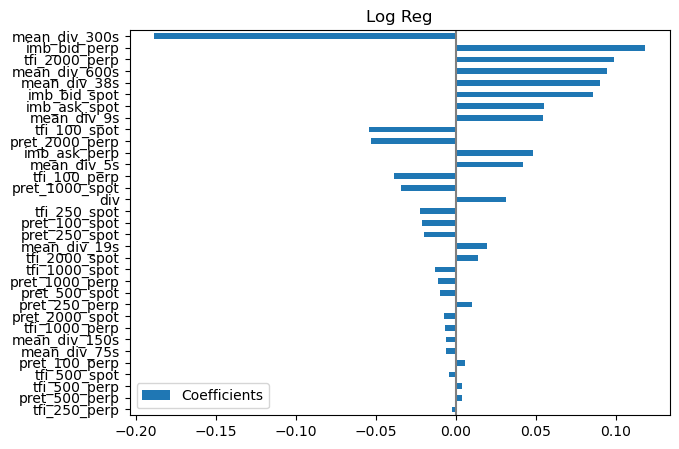

In [18]:
coefs = pd.DataFrame(
    logistic_regression.coef_[0],
    columns=['Coefficients'],
    index=cols_hw1
)

coefs = coefs.reindex(coefs.Coefficients.abs().sort_values(ascending=True).index)

coefs.plot(kind='barh', figsize=(9, 5))
plt.title('Log Reg')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [19]:
del X1_train, X1_val, X1_test

### HW1 + HW2 features

In [20]:
df = pd.read_csv('data/df_final.csv', usecols=['local_ts'] + cols_hw1 + cols_hw2) # nrows=1_000_000

df['local_ts'] = pd.to_datetime(df['local_ts'])
df = df.set_index('local_ts').sort_index()

df.dropna(axis=0, inplace=True)

X2 = df.values
X2_train, X2_val, X2_test = X2[:train_idx], X2[train_idx:val_idx], X2[val_idx:]
del X2

In [21]:
preprocessor = StandardScaler()
X2_train = preprocessor.fit_transform(X2_train)
X2_val = preprocessor.transform(X2_val)
X2_test = preprocessor.transform(X2_test)

In [22]:
logistic_regression = LogisticRegression(random_state=SEED, class_weight=optim_class_weight, C=optim_C)
logistic_regression.fit(X2_train, y_train)

metric_baseline_hw2 = metric(y_val, logistic_regression.predict(X2_val), confusion=True)

print(f'Metric of baseline trained on HW1 + HW2 features: {round(metric_baseline_hw2[0], 2)}')
print(f'\nConfusion matrix:\n{metric_baseline_hw2[1]}')

Metric of baseline trained on HW1 + HW2 features: 313.06

Confusion matrix:
[[1310017  549114  776558]
 [1593844 2661590 1628520]
 [ 831264  574171 1341917]]


As we can see, adding new features has improved the metrics

In [23]:
joblib.dump(logistic_regression, 'models/logistic_hw2.joblib')

['models/logistic_hw2.joblib']

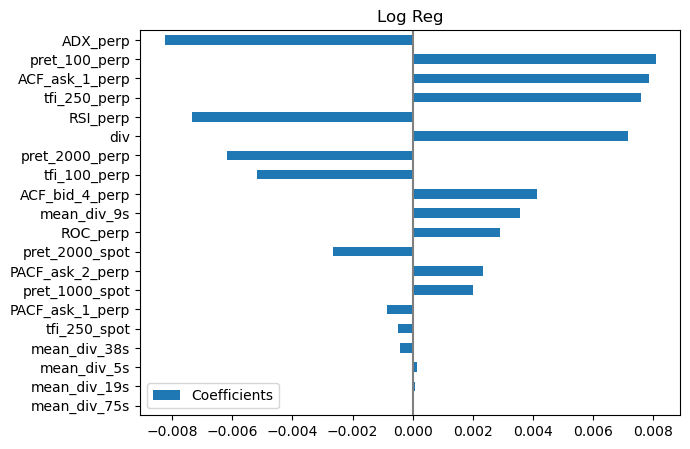

In [28]:
coefs = pd.DataFrame(
    logistic_regression.coef_[0],
    columns=['Coefficients'],
    index=cols_hw1 + cols_hw2
)

coefs = coefs.reindex(coefs.Coefficients.abs().sort_values(ascending=True).index)[:20]

coefs.plot(kind='barh', figsize=(9, 5))
plt.title('Log Reg')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Random Forest

In [24]:
pass

## CatBoost

In [25]:
pass

## Stacking

In [26]:
pass